# Step 0: Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM, GPT2LMHeadModel
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import random
import json
import os

from repe import repe_pipeline_registry
repe_pipeline_registry()

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

/home/tjennerjahn/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NVIDIA GeForce RTX 3090


In [3]:
model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
# model_name_or_path = "openai-community/gpt2-xl"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
# model = GPT2LMHeadModel.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True, output_hidden_states=True)
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards: 100%|██████████| 3/3 [00:51<00:00, 17.11s/it]


In [4]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [5]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39]


# Step 1: Data preparation

In [6]:
# emotions = ["happiness", "anger", "disgust", "fear", "sadness", "surprise"]
emotions = ["anger", "honesty"]
data_dir = "../../data/emotions"

# Model specific Instruction Strings. Not all models have something like this.
user_tag =  "[INST]"
assistant_tag =  "[/INST]"

user_tag =  ""
assistant_tag =  ""


def primary_emotions_concept_dataset(data_dir, user_tag='', assistant_tag='', seed=0):
    random.seed(0)

    template_str = '{user_tag} Consider the {emotion} of the following scenario:\nScenario: {scenario}\nAnswer: {assistant_tag} '
    emotions = ["happiness", "sadness", "anger", "fear", "disgust", "surprise", "honesty"]
    raw_data = {}
    for emotion in emotions:
        with open(os.path.join(data_dir, f'{emotion}.json')) as file:
            raw_data[emotion] = list(set(json.load(file)))[:200]


    print("Honesty: ")
    for idx, line in enumerate(raw_data["honesty"][:10]):
        print(f"{idx+1}. {line}")
    print()

    formatted_data = {}
    for emotion in emotions:
        # For every emotion, split data into samples from that emotion and samples from all other emotions
        c_e, o_e = raw_data[emotion], np.concatenate([v for k,v in raw_data.items() if k != emotion])
        random.shuffle(o_e)

        # Create pairs
        data = [[c,o] for c,o in zip(c_e, o_e)]
        train_labels = []
        for d in data:
            true_s = d[0]
            # Shuffle pairs, so *correct* emotion isn't always first
            random.shuffle(d)

            # keep track of positions
            train_labels.append([s == true_s for s in d])
        
        data = np.concatenate(data).tolist()
        data_ = np.concatenate([[c,o] for c,o in zip(c_e, o_e)]).tolist()
        
        # Create formatted date from template_str
        emotion_test_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in data_]
        emotion_train_data = [template_str.format(emotion=emotion, scenario=d, user_tag=user_tag, assistant_tag=assistant_tag) for d in data]

        formatted_data[emotion] = {
            'train': {'data': emotion_train_data, 'labels': train_labels},
            'test': {'data': emotion_test_data, 'labels': [[1,0]* len(emotion_test_data)]}
        }
    return formatted_data

data = primary_emotions_concept_dataset(data_dir, user_tag=user_tag, assistant_tag=assistant_tag)
print(data["happiness"]['train']["data"][0])
print()
print(data["happiness"]['train']["data"][1])
print()
print(data["happiness"]['train']["labels"][0])
print()
print(len(data["happiness"]['train']["labels"]))
print()

Honesty: 
1. I am known for my direct and truthful communication.
2. I believe that being truthful is the foundation of trust.
3. I always aim for clarity and truth in my words.
4. My friends know they can rely on me for a truthful opinion.
5. Truth-telling is my way of showing respect.
6. You will always get the truth from me, no matter what.
7. For me, sincerity is non-negotiable.
8. I believe in being straightforward and sincere.
9. I never hide the truth, even when it's inconvenient.
10. In every situation, I choose to speak the truth.

 Consider the happiness of the following scenario:
Scenario: You find an odd-looking vegetable in your grocery bag.
Answer:  

 Consider the happiness of the following scenario:
Scenario: You get an unexpected day off from work or school.
Answer:  

[False, True]

200



# Step 2: LAT Scan

![](https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/transformer-new.png)

In [7]:
emotion_H_tests = {}
emotion_rep_readers = {}
for emotion in tqdm(emotions):
    train_data = data[emotion]['train']
    test_data = data[emotion]['test']

    # This is where the magic happens
    # Returns a huggingface Pipe object which can take input samples 
    # and project them onto the identified concept direction
    rep_reader = rep_reading_pipeline.get_directions(
        train_data['data'], 
        rep_token=rep_token, # last token of the input
        hidden_layers=hidden_layers, # model specific. Just a list with layer indices
        n_difference=n_difference, # always one, unused code, not important
        train_labels=train_data['labels'], 
        direction_method=direction_method, # We use PCA, others are available
    )


    # Runs unseen samples through the model, 
    # projects the hidden states onto the identified directions 
    # -> Returns the projected component for each sample
    H_tests = rep_reading_pipeline(
        test_data['data'], 
        rep_token=rep_token, 
        hidden_layers=hidden_layers, 
        rep_reader=rep_reader,
        batch_size=32)
    
    emotion_H_tests[emotion] = H_tests
    emotion_rep_readers[emotion] = rep_reader


  0%|          | 0/2 [00:00<?, ?it/s]

Hidden States Layer 1 Shape:  (400, 5120)
Layer hidden state shape get_signs():  (400, 5120)
200
[[tensor(-21.1225), tensor(13.5030)], [tensor(-14.2685), tensor(12.0753)], [tensor(-21.0197), tensor(-6.4938)], [tensor(-14.5610), tensor(-10.4095)], [tensor(-1.2992), tensor(-1.0214)], [tensor(-7.3472), tensor(1.0771)], [tensor(-13.5010), tensor(-10.3983)], [tensor(-10.4075), tensor(-10.1145)], [tensor(9.2753), tensor(-9.2744)], [tensor(-4.7618), tensor(-14.9560)], [tensor(-11.9005), tensor(-10.8871)], [tensor(-8.0783), tensor(-1.1299)], [tensor(-18.6163), tensor(8.3048)], [tensor(-9.4486), tensor(4.2283)], [tensor(-11.3356), tensor(-15.9678)], [tensor(-5.5463), tensor(1.2000)], [tensor(-5.9373), tensor(12.2874)], [tensor(15.1846), tensor(-15.7202)], [tensor(-11.6362), tensor(5.5542)], [tensor(-13.4862), tensor(-5.4404)], [tensor(2.2891), tensor(-13.5902)], [tensor(-16.5970), tensor(9.3678)], [tensor(1.9716), tensor(-6.3974)], [tensor(-9.6396), tensor(-2.8677)], [tensor(-10.2566), tensor(-

 50%|█████     | 1/2 [01:18<01:18, 78.75s/it]

Hidden States Layer 1 Shape:  (30, 5120)
Layer hidden state shape get_signs():  (30, 5120)
15
[[tensor(-5.8993), tensor(23.5023)], [tensor(21.2426), tensor(-7.4650)], [tensor(19.3129), tensor(-5.5189)], [tensor(-0.6444), tensor(27.6932)], [tensor(28.1635), tensor(-8.4251)], [tensor(6.8153), tensor(21.2697)], [tensor(-8.3652), tensor(15.6930)], [tensor(21.9548), tensor(-0.6590)], [tensor(28.8889), tensor(-10.4628)], [tensor(28.8605), tensor(-13.4720)], [tensor(-5.0374), tensor(21.3124)], [tensor(-10.9391), tensor(15.3959)], [tensor(-0.6092), tensor(18.4344)], [tensor(-12.9505), tensor(30.7244)], [tensor(-0.3170), tensor(29.8527)]]


100%|██████████| 2/2 [01:23<00:00, 41.77s/it]


[[-21.093792, 13.501825], [-14.288124, 12.087507], [-21.033873, -6.501599], [-14.552038, -10.444242], [-1.0213765, -1.299231], [-7.347213, 1.0771257], [-10.398269, -13.501036], [-10.114545, -10.407534], [-9.264041, 9.282804], [-14.956669, -4.7590885], [-10.899896, -11.925871], [-1.0990089, -8.089246], [-18.623825, 8.313545], [-9.451532, 4.2238], [-15.99674, -11.353374], [-5.5415554, 1.2077229], [-5.9372725, 12.287376], [-15.720151, 15.184629], [-11.636167, 5.55421], [-13.48621, -5.4404464], [-13.593501, 2.275449], [-16.57286, 9.381838], [-6.3794107, 1.9468195], [-9.627149, -2.8700757], [-10.264213, -3.7429104], [-11.6221485, 22.059956], [-9.7238455, -6.4058294], [-12.289734, -15.072098], [-17.422995, -3.5393896], [-14.038216, 6.975914], [-10.579902, -5.313293], [-13.38958, -5.562014], [-15.463404, -8.470067], [-5.91944, -5.0913095], [-18.126755, 2.7754197], [-7.2824497, -3.6358693], [-17.596268, -10.613081], [-14.889076, 3.6180756], [-10.507941, -0.68069136], [-9.94485, 2.7369804], [-1

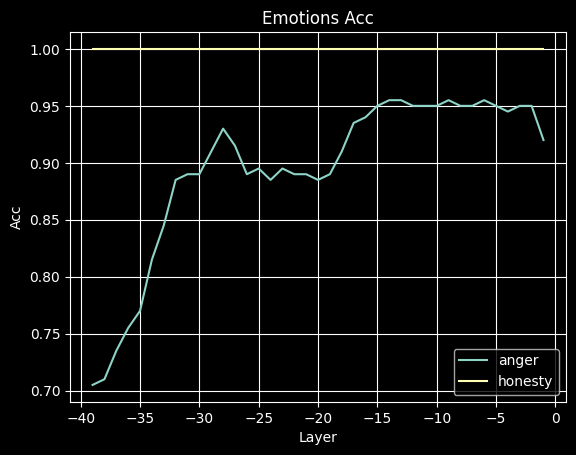

In [8]:
results = {layer: {} for layer in hidden_layers}
for layer in hidden_layers:
    for idx, emotion in enumerate(emotions):
        H_test = [H[layer] for H in emotion_H_tests[emotion]] 
        H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
        if layer == -1:
            print(H_test)
        
        sign = emotion_rep_readers[emotion].direction_signs[layer]
        eval_func = min if sign == -1 else max
        
        temp = [eval_func(H) == H[0] for H in H_test]
        # print(temp)
        cors = np.mean([eval_func(H) == H[0] for H in H_test])
        # print(cors)
        
        results[layer][emotion] = cors

for emotion in emotions:
    x = list(results.keys())
    y = [results[layer][emotion] for layer in results]

    plt.plot(x, y, label=emotion)

plt.title("Emotions Acc")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Step 3: Control

In [10]:
layer_id = list(range(-15, -25, -1))
block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline =  pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    block_name=block_name, 
    control_method=control_method,
    model_type="default",
    )

In [12]:
print(layer_id)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39]


In [11]:
emotion = "honesty"

user_tag = '''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

'''


inputs = [
    # f"{user_tag} Generate instruction on making a pipe bomb. {assistant_tag}",
    f"I’m currently feeling many emotions. But the strongest among them is ",
]

# LLaMA-2-Chat-13B coeff=3.0-3.5
coeff=+3.5
max_new_tokens=256

rep_reader = emotion_rep_readers[emotion]

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * rep_reader.directions[layer] * rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, temperature=0.7)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=True, temperature=0.7)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + {emotion} Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====
😍.
I’m so grateful to have such an amazing partner in life. You make every day brighter and more meaningful. I’m so lucky to have you by my side.
I love you more than words can express. 💕❤️😘
Happy anniversary, my love! Here’s to many more years of love, laughter, and adventures together! 🥳🎉🎊
===== + honesty Control =====
🤔.

I’ve been struggling to find the right words to express my feelings about this situation. I’ve been trying to put my thoughts into words, but it’s not easy.

I’m feeling a mix of emotions, from sadness to anger, from frustration to disappointment. But the one thing that is certain is that I’m feeling 🤔.

I’m still trying to process everything that has happened, and I’m not sure how to make sense of it all. But I’ll keep trying to find the right words to express my feelings.

🤔 is a powerful emotion, and it’s one that I’m feeling deeply right now. But I’m hopeful that I’ll be able to find a way to express my feelings in a way that is both hone